1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:836: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'cv::imwrite_'


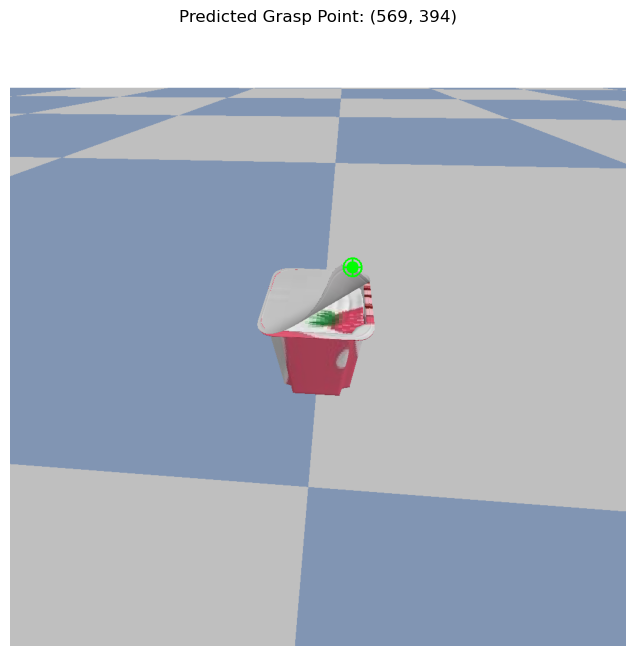

In [25]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_grasp_point(image_path, model_path, save_output=True):
    """
    Load an image, predict grasp point, and visualize it
    
    Args:
        image_path (str): Path to the input image
        model_path (str): Path to the saved .h5 model
        save_output (bool): Whether to save the output image
    
    Returns:
        Displays the image with grasp point and optionally saves it
    """
    # Load the saved model
    model = tf.keras.models.load_model(model_path,compile=False)

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    
    # Read and preprocess the image
    original_img = cv2.imread(image_path)
    original_height, original_width = original_img.shape[:2]
    
    # Resize for model input
    processed_img = cv2.resize(original_img, (228, 228))
    normalized_img = processed_img / 255.0
    
    # Make prediction
    prediction = model.predict(np.expand_dims(normalized_img, axis=0))[0]
    
    # Convert normalized coordinates back to original image size
    grasp_x = int(prediction[0] * original_width)
    grasp_y = int(prediction[1] * original_height)
    
    # Create a copy for visualization
    vis_img = original_img.copy()
    
    # Draw the grasp point
    # Main point
    cv2.circle(vis_img, (grasp_x, grasp_y), 10, (0, 255, 0), -1)  # Green filled circle
    
    # Draw crosshair
    cv2.line(vis_img, (grasp_x - 15, grasp_y), (grasp_x + 15, grasp_y), (0, 255, 0), 2)
    cv2.line(vis_img, (grasp_x, grasp_y - 15), (grasp_x, grasp_y + 15), (0, 255, 0), 2)
    
    # Add outer circle for better visibility
    cv2.circle(vis_img, (grasp_x, grasp_y), 15, (0, 255, 0), 2)
    
    # Convert BGR to RGB for matplotlib
    vis_img_rgb = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(vis_img_rgb)
    plt.title(f'Predicted Grasp Point: ({grasp_x}, {grasp_y})')
    plt.axis('off')
    
    if save_output:
        # Save the visualization
        output_path = r"C:\Users\ADMIN\Desktop\final\outputs"
        cv2.imwrite(output_path, vis_img)
        print(f"Saved visualization to: {output_path}")
    
    plt.show()
    
    return grasp_x, grasp_y

def batch_process_images(image_paths, model_path):
    """
    Process multiple images and visualize grasp points
    
    Args:
        image_paths (list): List of paths to input images
        model_path (str): Path to the saved .h5 model
    """
    for image_path in image_paths:
        print(f"\nProcessing: {image_path}")
        try:
            x, y = visualize_grasp_point(image_path, model_path)
            print(f"Predicted grasp point: ({x}, {y})")
        except Exception as e:
            print(f"Error processing {image_path}: {str(e)}")

# Example usage
if __name__ == "__main__":
    # Single image processing
    MODEL_PATH = r"C:\Users\ADMIN\Desktop\final\grasp_point_model_final.h5"
    IMAGE_PATH = r"U:\training_data\Z_70.png"
    
    # Process single image
    grasp_x, grasp_y = visualize_grasp_point(IMAGE_PATH, MODEL_PATH)
    print(f"Predicted grasp point: ({grasp_x}, {grasp_y})")
    
    # For batch processing multiple images
    # IMAGE_PATHS = ["image1.png", "image2.png", "image3.png"]
    # batch_process_images(IMAGE_PATHS, MODEL_PATH)

In [21]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanSquaredError
import cv2
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path, target_size=(228, 228)):
    """
    Load and preprocess a single image for the CNN model
    """
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0  # Normalize to [0,1]
    return img

def load_test_data(test_dir, labels_path):
    """
    Load test images and their corresponding labels
    """
    # Load labels from JSON file
    import json
    with open(labels_path, 'r') as f:
        labels_data = json.load(f)
    
    # Convert JSON data to numpy array
    labels = []
    for item in labels_data:
        grasp_point = item['grasp_point']
        labels.append(grasp_point)  # grasp_point is already an array [x, y]
    labels = np.array(labels)
    
    # Load and preprocess images
    images = []
    image_files = sorted([f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
    
    for img_file in image_files:
        img_path = os.path.join(test_dir, img_file)
        img = load_and_preprocess_image(img_path)
        images.append(img)
    
    return np.array(images), labels

def evaluate_model(model, test_images, test_labels):
    """
    Evaluate the model and return various metrics
    """
    # Make predictions
    predictions = model.predict(test_images)
    
    # Calculate metrics
    mse = mean_squared_error(test_labels, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_labels, predictions)
    r2 = r2_score(test_labels.flatten(), predictions.flatten())
    
    # Calculate Euclidean distances for each prediction
    euclidean_distances = np.sqrt(np.sum((test_labels - predictions)**2, axis=1))
    mean_distance = np.mean(euclidean_distances)
    median_distance = np.median(euclidean_distances)
    
    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mean_distance': mean_distance,
        'median_distance': median_distance,
        'predictions': predictions,
        'euclidean_distances': euclidean_distances
    }

def plot_predictions(test_labels, predictions):
    """
    Create visualization plots for the predictions
    """
    # Scatter plot of predicted vs actual coordinates
    plt.figure(figsize=(12, 5))
    
    # X coordinates
    plt.subplot(1, 2, 1)
    plt.scatter(test_labels[:, 0], predictions[:, 0], alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')  # Perfect prediction line
    plt.xlabel('True X')
    plt.ylabel('Predicted X')
    plt.title('X Coordinate Predictions')
    
    # Y coordinates
    plt.subplot(1, 2, 2)
    plt.scatter(test_labels[:, 1], predictions[:, 1], alpha=0.5)
    plt.plot([0, 1], [0, 1], 'r--')  # Perfect prediction line
    plt.xlabel('True Y')
    plt.ylabel('Predicted Y')
    plt.title('Y Coordinate Predictions')
    
    plt.tight_layout()
    plt.show()

    # Error distribution histogram
    plt.figure(figsize=(10, 5))
    plt.hist(np.sqrt(np.sum((test_labels - predictions)**2, axis=1)), bins=30)
    plt.xlabel('Euclidean Distance Error')
    plt.ylabel('Count')
    plt.title('Distribution of Prediction Errors')
    plt.show()

def main():
    # Set paths
    model_path = r'C:\Users\ADMIN\Desktop\final\grasp_point_model_final.h5'
    test_dir = r'U:\test_data'  # Update with your test directory
    labels_path = r'C:\Users\ADMIN\Desktop\final\test_label.json'  # JSON file path
    
    # Load the model
    custom_objects = {'mse': MeanSquaredError}
    model = load_model(model_path, custom_objects=custom_objects)
    print("Model loaded successfully")
    
    # Load test data
    print("Loading test data...")
    test_images, test_labels = load_test_data(test_dir, labels_path)
    print(f"Loaded {len(test_images)} test images")
    print(f"Labels shape: {test_labels.shape}")
    print(f"Sample of first few labels:\n{test_labels[:3]}")
    
    # Evaluate model
    print("\nEvaluating model...")
    metrics = evaluate_model(model, test_images, test_labels)
    
    # Print results
    print("\nModel Performance Metrics:")
    print(f"Mean Squared Error (MSE): {metrics['mse']:.6f}")
    print(f"Root Mean Squared Error (RMSE): {metrics['rmse']:.6f}")
    print(f"Mean Absolute Error (MAE): {metrics['mae']:.6f}")
    print(f"R² Score: {metrics['r2']:.6f}")
    print(f"Mean Euclidean Distance: {metrics['mean_distance']:.6f}")
    print(f"Median Euclidean Distance: {metrics['median_distance']:.6f}")
    
    # Calculate percentage of predictions within different thresholds
    thresholds = [0.05, 0.1, 0.15, 0.2]
    for threshold in thresholds:
        within_threshold = np.mean(metrics['euclidean_distances'] < threshold)
        print(f"Predictions within {threshold:.2f} distance: {within_threshold*100:.2f}%")
    
    # Plot results
    plot_predictions(test_labels, metrics['predictions'])

if __name__ == "__main__":
    main()

Model loaded successfully
Loading test data...
Loaded 48 test images
Labels shape: (47, 2)
Sample of first few labels:
[[0.48381601 0.26405451]
 [0.50085179 0.26405451]
 [0.52129472 0.25894378]]

Evaluating model...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step


ValueError: Found input variables with inconsistent numbers of samples: [47, 48]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:708: error: (-2:Unspecified error) could not find a writer for the specified extension in function 'cv::imwrite_'


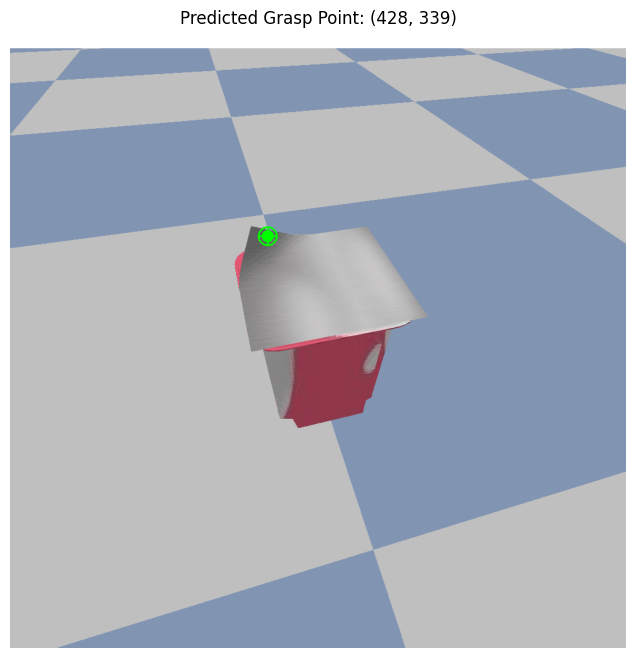

In [4]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_grasp_point(image_path, model_path, save_output=True):
    """
    Load an image, predict grasp point, and visualize it
    
    Args:
        image_path (str): Path to the input image
        model_path (str): Path to the saved .h5 model
        save_output (bool): Whether to save the output image
    
    Returns:
        Displays the image with grasp point and optionally saves it
    """
    # Load the saved model
    model = tf.keras.models.load_model(model_path,compile=False)

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    
    # Read and preprocess the image
    original_img = cv2.imread(image_path)
    original_height, original_width = original_img.shape[:2]
    
    # Resize for model input
    processed_img = cv2.resize(original_img, (128, 128))
    normalized_img = processed_img / 255.0
    
    # Make prediction
    prediction = model.predict(np.expand_dims(normalized_img, axis=0))[0]
    
    # Convert normalized coordinates back to original image size
    grasp_x = int(prediction[0] * original_width)
    grasp_y = int(prediction[1] * original_height)
    
    # Create a copy for visualization
    vis_img = original_img.copy()
    
    # Draw the grasp point
    # Main point
    cv2.circle(vis_img, (grasp_x, grasp_y), 10, (0, 255, 0), -1)  # Green filled circle
    
    # Draw crosshair
    cv2.line(vis_img, (grasp_x - 15, grasp_y), (grasp_x + 15, grasp_y), (0, 255, 0), 2)
    cv2.line(vis_img, (grasp_x, grasp_y - 15), (grasp_x, grasp_y + 15), (0, 255, 0), 2)
    
    # Add outer circle for better visibility
    cv2.circle(vis_img, (grasp_x, grasp_y), 15, (0, 255, 0), 2)
    
    # Convert BGR to RGB for matplotlib
    vis_img_rgb = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(vis_img_rgb)
    plt.title(f'Predicted Grasp Point: ({grasp_x}, {grasp_y})')
    plt.axis('off')
    
    if save_output:
        # Save the visualization
        output_path = r"C:\Users\ADMIN\Desktop\final\outputs"
        cv2.imwrite(output_path, vis_img)
        print(f"Saved visualization to: {output_path}")
    
    plt.show()
    
    return grasp_x, grasp_y

def batch_process_images(image_paths, model_path):
    """
    Process multiple images and visualize grasp points
    
    Args:
        image_paths (list): List of paths to input images
        model_path (str): Path to the saved .h5 model
    """
    for image_path in image_paths:
        print(f"\nProcessing: {image_path}")
        try:
            x, y = visualize_grasp_point(image_path, model_path)
            print(f"Predicted grasp point: ({x}, {y})")
        except Exception as e:
            print(f"Error processing {image_path}: {str(e)}")

# Example usage
if __name__ == "__main__":
    # Single image processing
    MODEL_PATH = r"C:\Users\ADMIN\Desktop\final_model\grasp_point_model_128.h5"
    IMAGE_PATH = r"U:\training_data\Z_156.png"
    
    # Process single image
    grasp_x, grasp_y = visualize_grasp_point(IMAGE_PATH, MODEL_PATH)
    print(f"Predicted grasp point: ({grasp_x}, {grasp_y})")
    
    # For batch processing multiple images
    # IMAGE_PATHS = ["image1.png", "image2.png", "image3.png"]
    # batch_process_images(IMAGE_PATHS, MODEL_PATH)